In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from lightning.pytorch import Trainer, seed_everything
from joblib import Parallel, delayed
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from src.models.cebra_factorvae_mlp import CEBRAFactorReg
from src.data.spike_datamodule import _SpikePairDataset
from preprocessing.prp import add_perceived_probs
from experiments.GradCAM1D import GradCAM1D
from experiments.PerNeuronImportance import PerNeuronImpartanceCEBRAFactorReg
from derivative import Kalman
from Dynamic_SINDy.timeVAE.utils2 import compute_derivative, library_size, sindy_library

c:\Users\qf1824\.local\share\mamba\envs\my_msc_proj\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\qf1824\.local\share\mamba\envs\my_msc_proj\lib\site-packages\cebra\integrations\sklearn\cebra.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Path to data

In [2]:
# 64 new
# ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_06_26/505926952829715205/f87cb26d029144bebb64ceb5ba5f668d/checkpoints/epoch=84-step=510.ckpt'

# 16 new
ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_07_01/664223543704393700/f57ea90a7a7e42d48277c3450cf94c63/checkpoints/epoch=65-step=396.ckpt'
# 16 old
# ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_06_26/505926952829715205/c4fdbd091a954de6af1c6a160ea6a791/checkpoints/epoch=43-step=220.ckpt'
# ckpt_path = 'D:/Arsenii temporrary/arseniis_msc_proj_ray_tune/mlruns_06_26/505926952829715205/c4fdbd091a954de6af1c6a160ea6a791/checkpoints/epoch=41-step=210.ckpt'

session = 'data/processed/spikes.npz'
prpd_path = 'data/processed/prpd.npz'
droot = Path('C:/Users/qf1824/Desktop/coding/Arseniis_Msc_proj/data/JPAS_0023_20230922')

spikes = np.load(session)['arr_0']
prpd = np.load(prpd_path)['arr_0']
# shift by one
prpd[1:] = prpd[:-1]

Load Dataset

In [3]:
full_ds = _SpikePairDataset(spikes, prpd, contrastive=True)
loader = DataLoader(
    full_ds,
    batch_size=prpd.shape[0],
    shuffle=False,
    num_workers=0
)

Load Model and validate on held-out part of the data

In [4]:
model = CEBRAFactorReg.load_from_checkpoint(ckpt_path, map_location='cuda:0')
model.eval()

trainer = Trainer(
    accelerator='gpu',
    devices=1,
    logger=False,
    enable_checkpointing=False,
    max_epochs=1
)

metrics = trainer.validate(model, dataloaders=loader, verbose=False)[0]
for k, v in metrics.items():
    print(f'{k}: {v:.4f}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]
val/loss/info_nce: 1.7096
val/loss/tc: 0.0084
val/loss/recon_mse: 0.0002
val/loss/total: 1.7180
val/loss/prpd_mse: 0.0798
val/prpd_r2: 0.7184


Encode latents for the trial-aligned spike array

In [5]:
seed_everything(42)
model.to('cuda')

spike_tensor = torch.as_tensor(spikes, dtype=torch.float32)
dataset = TensorDataset(spike_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=False)

all_latents = []
with torch.no_grad():
    for (x,) in loader:
        x = x.to('cuda').transpose(1, 2)
        z = model.model.encode(x)
        all_latents.append(z.cpu())

latents = torch.cat(all_latents).numpy()
print(latents.shape)

Seed set to 42


(241, 16)


Lasso bagging to assess stability and weights

In [6]:
N_REPEATS = 100000
N_SPLITS = 5
ALPHA = 1e-3
N_JOBS = -1

D = latents.shape[1]
all_r2 = np.empty(N_REPEATS)
select = np.zeros((N_REPEATS, D), int)
weights = np.zeros((N_REPEATS, D))

def one_repeat(seed):
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=seed)
    r2_accum = []
    nonzero = np.zeros(D, bool)
    weight = np.zeros(D)

    for train_idx, val_idx in kf.split(latents):
        z_tr, z_val = latents[train_idx], latents[val_idx]
        y_tr, y_val = prpd[train_idx], prpd[val_idx]

        clf = Lasso(alpha=ALPHA, max_iter=1000)
        clf.fit(z_tr, y_tr)

        y_pred = clf.predict(z_val)
        r2_accum.append(r2_score(y_val, y_pred))

        sel = clf.coef_ != 0.0
        nonzero |= sel
        weight += np.abs(clf.coef_)

    return np.mean(r2_accum), nonzero.astype(int), weight / N_SPLITS

results = Parallel(n_jobs=N_JOBS, verbose=False)(
    delayed(one_repeat)(seed) for seed in range(N_REPEATS)
)

for i, (r2, nz, w) in enumerate(results):
    all_r2[i] = r2
    select[i] = nz
    weights[i] = w

print(f'mean R2 +/- SD: {all_r2.mean():.4f} +/- {all_r2.std(ddof=1):.4f}')
print(f'median R2: {np.median(all_r2):.4f}')

freq = select.mean(axis=0)
mean_abs_w = np.where(freq > 0, weights.sum(axis=0) / select.sum(axis=0), 0.0)

important = np.argsort(-freq)[:10]
print('Top 10 latent dimensions by stability:')
for idx in important:
    print(f'dim {idx:2d} freq={freq[idx]:.3f} w={mean_abs_w[idx]:.4f}')

idx_top4 = (-mean_abs_w).argsort()[:4]

mean R2 +/- SD: 0.7526 +/- 0.0073
median R2: 0.7534
Top 10 latent dimensions by stability:
dim  3 freq=1.000 w=0.9294
dim  4 freq=1.000 w=0.1705
dim  8 freq=1.000 w=1.1769
dim 12 freq=1.000 w=0.8713
dim 13 freq=1.000 w=0.5344
dim 15 freq=1.000 w=0.4360
dim  5 freq=0.997 w=0.0797
dim 10 freq=0.987 w=0.0284
dim 14 freq=0.960 w=0.0289
dim  6 freq=0.955 w=0.0350


Covariance of top 4 latents

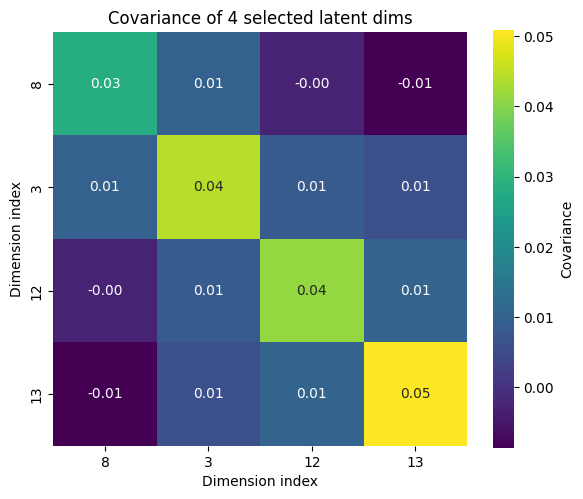

In [7]:
lat_sub = latents[:, idx_top4]
cov = np.cov(lat_sub, rowvar=False)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cov,
    annot=True,
    fmt='.2f',
    cmap='viridis',
    cbar_kws={'label': 'Covariance'},
    square=True,
    xticklabels=idx_top4,
    yticklabels=idx_top4
)
plt.title(f'Covariance of {len(idx_top4)} selected latent dims')
plt.xlabel('Dimension index')
plt.ylabel('Dimension index')
plt.tight_layout()
plt.show()

Load behavior, compute belief features

In [8]:
bp = droot / 'BEHAV'

with open(bp / 'metrics.json') as f:
    behav = json.load(f)

metrics_b = behav['metrics']
trials = pd.DataFrame(metrics_b['trials'])

INIT_PRP = 0.5
trials = add_perceived_probs(trials, init_p=INIT_PRP)

sort_idx = (-mean_abs_w).argsort()
Z = latents[:, sort_idx]
y = prpd
cv = KFold(n_splits=10, shuffle=True, random_state=0)

r2_single = []
for k in range(Z.shape[1]):
    r2_k = cross_val_score(
        Ridge(alpha=1.0),
        Z[:, k][:, None],
        y,
        cv=cv,
        scoring='r2'
    ).mean()
    r2_single.append(r2_k)

order = np.argsort(r2_single)[::-1]
cum_r2 = np.cumsum(np.array(r2_single)[order])

print('Top dims and marginal R2:')
for i, j in enumerate(order[:5]):
    print(f'dim{j}: {r2_single[j]:.2f}')
print(f'Cumulative R2 after 5 dims = {cum_r2[4]:.2f}')

Top dims and marginal R2:
dim0: 0.52
dim4: 0.25
dim6: 0.22
dim3: 0.15
dim1: 0.11
Cumulative R2 after 5 dims = 1.24


Plot belief vs true probabilities and top latents over trials

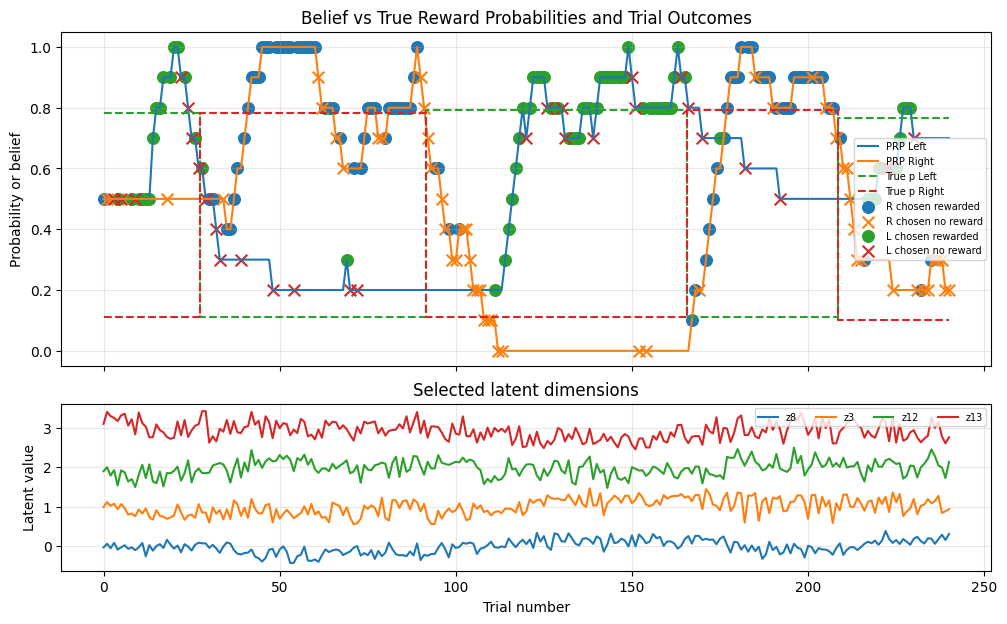

In [9]:
trls = trials[~trials['set reward probabs l/r'].isna()].copy()[:latents.shape[0]].reset_index()
trial_idx = trls.index
sel_z = latents[:, idx_top4]

fig, (ax_belief, ax_z) = plt.subplots(
    2, 1, figsize=(12, 7), sharex=True,
    gridspec_kw={'height_ratios': [3, 1.5], 'hspace': 0.15}
)

true_prob = np.array(trls['set reward probabs l/r'].tolist())
trls['true_pL'], trls['true_pR'] = true_prob[:, 0], true_prob[:, 1]

ax = ax_belief
ax.plot(trls.index, trls['PRPl'], label='PRP Left')
ax.plot(trls.index, trls['PRPr'], label='PRP Right')

ax.step(trls.index, trls['true_pL'], linestyle='--', where='mid', label='True p Left')
ax.step(trls.index, trls['true_pR'], linestyle='--', where='mid', label='True p Right')

right = trls['choice'].str.lower().eq('r')
left = trls['choice'].str.lower().eq('l')

ax.scatter(trls.index[right & trls['rewarded']],
           trls.loc[right & trls['rewarded'], 'PRPr'],
           marker='o', s=70, label='R chosen rewarded')
ax.scatter(trls.index[right & ~trls['rewarded']],
           trls.loc[right & ~trls['rewarded'], 'PRPr'],
           marker='x', s=70, label='R chosen no reward')

ax.scatter(trls.index[left & trls['rewarded']],
           trls.loc[left & trls['rewarded'], 'PRPl'],
           marker='o', s=70, label='L chosen rewarded')
ax.scatter(trls.index[left & ~trls['rewarded']],
           trls.loc[left & ~trls['rewarded'], 'PRPl'],
           marker='x', s=70, label='L chosen no reward')

ax.set_ylabel('Probability or belief')
ax.set_ylim(-0.05, 1.05)
ax.set_title('Belief vs True Reward Probabilities and Trial Outcomes')
ax.legend(fontsize=7, loc='right')
ax.grid(alpha=0.3)

color_cycle = plt.cm.tab10.colors
for d in range(sel_z.shape[1]):
    ax_z.plot(trial_idx, sel_z[:, d] + d, label=f'z{idx_top4[d]}', color=color_cycle[d % 10])

ax_z.set_ylabel('Latent value')
ax_z.set_xlabel('Trial number')
ax_z.set_title('Selected latent dimensions')
ax_z.grid(alpha=0.3)
ax_z.legend(ncol=5, fontsize=7, loc='upper right')

plt.tight_layout()
plt.show()

Smoothed latents on continuous windows

In [10]:
dp = droot / 'PHY_AK/uploaded_folder/JPAS_0023_20230922'

spike_clusters = np.load(dp / 'spike_clusters.npy')
spike_times = np.load(dp / 'spike_times_milliseconds_sync_to_behav.npy')
clust_qa = pd.read_csv(dp / 'cluster_group.tsv', sep='\t')

good_unit_id = clust_qa[clust_qa.group == 'good'].cluster_id.tolist()
good_units_mask = np.isin(spike_clusters, good_unit_id)

good_units = spike_clusters[good_units_mask]
good_times = spike_times[good_units_mask]
spike_df = pd.DataFrame({'unit': good_units, 'time_ms': good_times})

BEHAV_LAG_MS = 200
WIN = 800
WIN_STEP = 400
BIN_MS = 10
normalizer = 5

units = np.sort(spike_df['unit'].unique())
unit2col = {u: i for i, u in enumerate(units)}
T = WIN // BIN_MS
n_units = len(units)

t_start = spike_df.time_ms.values[0]
t_end = spike_df.time_ms.values[-1]
n_windows = int((t_end - t_start - WIN) // WIN_STEP + 1)

spike_tensor = np.zeros((n_windows, T, n_units), dtype=np.uint8)
times = []

i = 0
while (t_start + WIN) < t_end:
    t_start_ms = t_start - BEHAV_LAG_MS
    t_end_ms = t_start + WIN - BEHAV_LAG_MS
    t = t_start + (WIN / 2)
    times.append(t)

    m = (spike_df.time_ms.values >= t_start_ms) & (spike_df.time_ms.values < t_end_ms)
    sub = spike_df.loc[m]

    if sub.empty:
        t_start += WIN_STEP
        continue

    bin_idx = ((sub.time_ms.values - t_start_ms) // BIN_MS).astype(np.int64)
    unit_idx = sub.unit.map(unit2col).values.astype(np.int64)
    np.add.at(spike_tensor, (i, bin_idx, unit_idx), 1)

    i += 1
    t_start += WIN_STEP

spike_tensor = spike_tensor.astype(np.float32) / normalizer
times = np.array(times)

with torch.no_grad():
    x = torch.from_numpy(spike_tensor).to('cuda').transpose(1, 2)
    z = model.model.encode(x)

latents = z.cpu().numpy()
print(latents.shape)

(3498, 16)


Align and plot latents, true reward probability and prpd

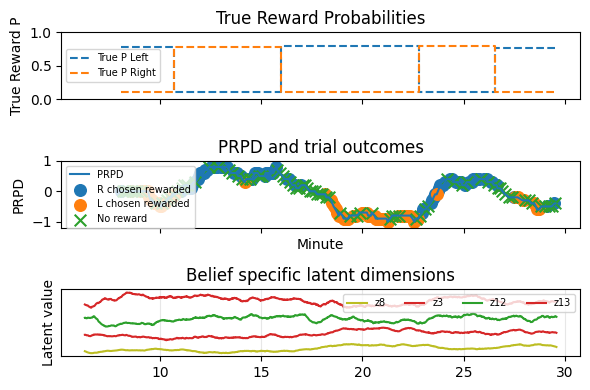

In [11]:
trls = trials[~trials['set reward probabs l/r'].isna()].copy()[:latents.shape[0]].reset_index()
trls['t_min'] = trls['t chosen'] / (1000 * 60)
t_min_latents = times / (1000 * 60)
trls = trls[trls.t_min <= (t_min_latents[-1])]

true_prob = np.array(trls['set reward probabs l/r'].tolist())
trls['true_pL'], trls['true_pR'] = true_prob[:, 0], true_prob[:, 1]

plt.close()
fig, (true_p_ax, prpd_ax, ax_z) = plt.subplots(nrows=3, figsize=(6, 4), sharex=True)

true_p_ax.step(trls.t_min, trls['true_pL'], linestyle='--', where='mid', label='True P Left')
true_p_ax.step(trls.t_min, trls['true_pR'], linestyle='--', where='mid', label='True P Right')
true_p_ax.set_ylabel('True Reward P')
true_p_ax.set_ylim(0, 1)
true_p_ax.legend(fontsize=7)

right = trls['choice'].str.lower().eq('r')
left = trls['choice'].str.lower().eq('l')

prpd_ax.plot(trls.t_min, trls['PRPD'], label='PRPD')
prpd_ax.scatter(trls.t_min[right & trls['rewarded']],
                trls.loc[right & trls['rewarded'], 'PRPD'],
                marker='o', s=70, label='R chosen rewarded')
prpd_ax.scatter(trls.t_min[left & trls['rewarded']],
                trls.loc[left & trls['rewarded'], 'PRPD'],
                marker='o', s=70, label='L chosen rewarded')
prpd_ax.scatter(trls.t_min[~trls['rewarded']],
                trls.loc[~trls['rewarded'], 'PRPD'],
                marker='x', s=70, label='No reward')

color_cycle = plt.cm.tab10.colors
for i_d, j in enumerate(idx_top4):
    ax_z.plot(t_min_latents, np.convolve(latents[:, j], np.ones(80) / 80, mode='same') + i_d / 2,
              label=f'z{j}', color=color_cycle[j % 10])

ax_z.set_ylabel('Latent value')
ax_z.set_yticks([])
ax_z.grid(alpha=0.3)
ax_z.legend(ncol=5, fontsize=7, loc='upper right')
ax_z.set_title('Belief specific latent dimensions')

prpd_ax.set_xlabel('Minute')
prpd_ax.set_ylabel('PRPD')
true_p_ax.set_title('True Reward Probabilities')
prpd_ax.set_title('PRPD and trial outcomes')
prpd_ax.legend(fontsize=7, loc='upper left')
prpd_ax.set_ylim(-1.2, 1)

plt.tight_layout()
plt.show()

GradCAM over encoder conv layer

In [12]:
model.eval()
conv_layer = model.model.encoder.net[6]
gradcam = GradCAM1D(model, conv_layer)

x = torch.from_numpy(spike_tensor).to('cuda').transpose(1, 2)
cams, preds = gradcam(x)
cams_np = cams.cpu().numpy()
print(cams_np.shape)

(3498, 367)


downsample GradCAM across time windows and heatmap

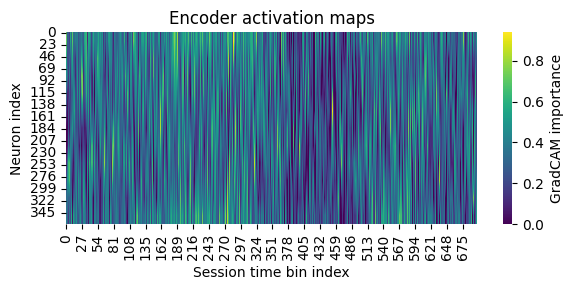

In [13]:
step = 5
cams_cat = cams
T_all, D_all = cams_cat.shape
rem = T_all % step
if rem:
    pad = step - rem
    last = cams_cat[-1:].expand(pad, -1)
    cams_cat = torch.cat([cams_cat, last], dim=0)
    T_all += pad

cams_ds = cams_cat.view(T_all // step, step, D_all).mean(dim=1)

plt.figure(figsize=(6, 3))
sns.heatmap(
    cams_ds.cpu().numpy().T,
    cmap='viridis',
    cbar_kws={'label': 'GradCAM importance'}
)
plt.title('Encoder activation maps')
plt.xlabel('Session time bin index')
plt.ylabel('Neuron index')
plt.tight_layout()
plt.show()

Saliancy maps

torch.Size([3498, 367, 80])
(3498, 80, 367)


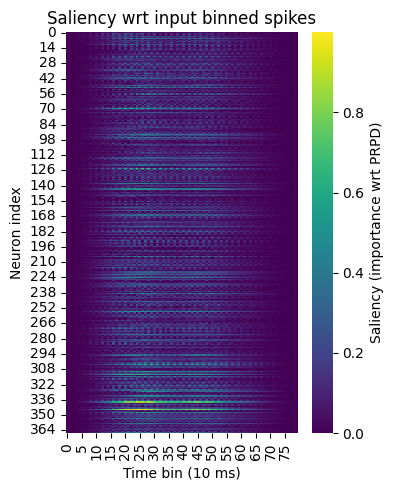

: 

In [ ]:
per_n_gradcam = PerNeuronImpartanceCEBRAFactorReg(model)
x = torch.from_numpy(spike_tensor).to('cuda').transpose(1, 2)
neuron_cams, preds = per_n_gradcam(x)
zero_threshold = 0.2

print(neuron_cams.shape)
print(spike_tensor.shape)

plt.figure(figsize=(4, 5))
sns.heatmap(
    neuron_cams.cpu().numpy()[4],
    cmap='viridis',
    cbar_kws={'label': 'Saliency (importance wrt PRPD)'}
)
plt.title('Saliency wrt input binned spikes')
plt.xlabel('Time bin (10 ms)')
plt.ylabel('Neuron index')
plt.tight_layout()
plt.show()

Saliency maps for prpd spectrum

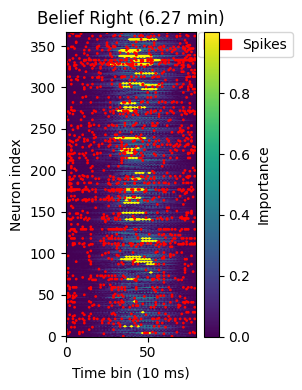

In [ ]:
max_idx = np.argmax(preds.cpu().numpy())
min_idx = np.argmin(preds.cpu().numpy())
mid_idx = np.argmin(np.abs(preds.cpu().numpy()))

for window_n, prpd_val in [[max_idx, 'Belief Right'], [min_idx, 'Belief Left'], [mid_idx, 'Belief Unsure']]:
    saliency = neuron_cams.cpu().numpy()[window_n].T
    spikes_win = spike_tensor[window_n]

    percentile = 99
    threshold = np.percentile(saliency, percentile)
    saliency_thresh = saliency.copy()
    saliency_thresh[saliency_thresh < threshold] = 0

    fig, ax = plt.subplots(figsize=(3, 4))
    im = ax.imshow(
        saliency.T,
        aspect='auto',
        origin='lower',
        cmap='viridis',
        zorder=0
    )
    plt.colorbar(im, ax=ax, label='Importance')

    ax.contour(
        saliency_thresh.T,
        levels=5,
        colors='yellow',
        linewidths=0.5,
        zorder=1
    )

    ys, xs = np.where(spikes_win.T > 0)
    ax.scatter(xs, ys, s=4, c='red', marker='o', edgecolors='none', zorder=2)

    ax.set_ylabel('Neuron index')
    ax.set_xlabel('Time bin (10 ms)')
    ax.set_title(f'{prpd_val} ({window_n * 0.4 / 60:.2f} min)')

    spike_patch = mpatches.Patch(color='red', label='Spikes')
    ax.legend(handles=[spike_patch], loc='upper left', bbox_to_anchor=(1.02, 1.0), borderaxespad=0)

    plt.tight_layout()
    plt.show()